# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.  
Значение метрики MAE модели на тестовой выборке должно быть не больше 8.
    
Исходные данные: набор фотографий людей с указанием возраста.

In [1]:
# импортируем библиотеки
import os
import random
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

## Исследовательский анализ данных

### Обзор данных

**Откроим файл с данными, изучим общую информацию.**

In [2]:
# читаем данные
path = '/datasets/faces/'
pth1 = path + 'labels.csv'
pth2 = 'https://restricted/datasets/faces/labels.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
else:
    try:
        data = pd.read_csv(pth2)
    except:
        print('Something is wrong, datasets not found!!!')

In [3]:
# Выведем общую инф о df
def df_info(df):
    display(df.head())
    df.info()
    display(df.describe())
    print("Количество дубликатов:", df.duplicated().sum())

def nan_info(df):
    zero_val = (df == 0).astype(int).sum(axis=0)
    zero_val_percent =  round(zero_val / len(df) * 100, 2)
    mis_val = df.isnull().sum()
    mis_val_percent = round(mis_val / len(df) * 100, 2)
    
    info_table = pd.concat([zero_val, zero_val_percent, mis_val, mis_val_percent], axis=1)
    info_table = info_table.rename(
            columns={0: 'Нулевые значения', 1: '% значений', 2: 'Кол-во пропусков', 3: '% пропусков'})
    display(info_table)
    print("Данные представлены в", df.shape[1], "столбцах и", df.shape[0], "строках")
    print("В", info_table[info_table.iloc[:, 2] != 0].shape[0], "столбцах имеются пропуски в кол-ве", mis_val.sum(), "или " + str(round(mis_val.sum() / len(df) * 100, 2)) + "%")

In [4]:
df_info(data)
nan_info(data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Количество дубликатов: 0


,Нулевые значения,% значений,Кол-во пропусков,% пропусков
file_name,0,0.0,0,0.0
real_age,0,0.0,0,0.0


Данные представлены в 2 столбцах и 7591 строках
В 0 столбцах имеются пропуски в кол-ве 0 или 0.0%


Для качественного обучения модели исходных данных мало, в связи с этим для тобучающей выборки будем использовать агументацию

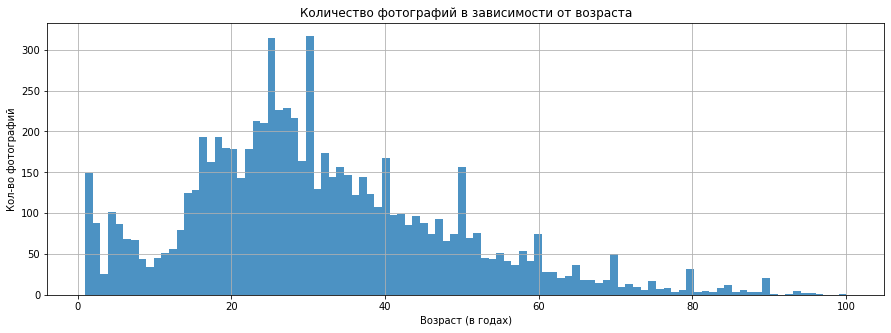

In [5]:
data.hist(figsize=(15, 5), bins=100, alpha=0.8)
plt.title('Количество фотографий в зависимости от возраста')
plt.xlabel('Возраст (в годах)')
plt.ylabel('Кол-во фотографий')
plt.show()

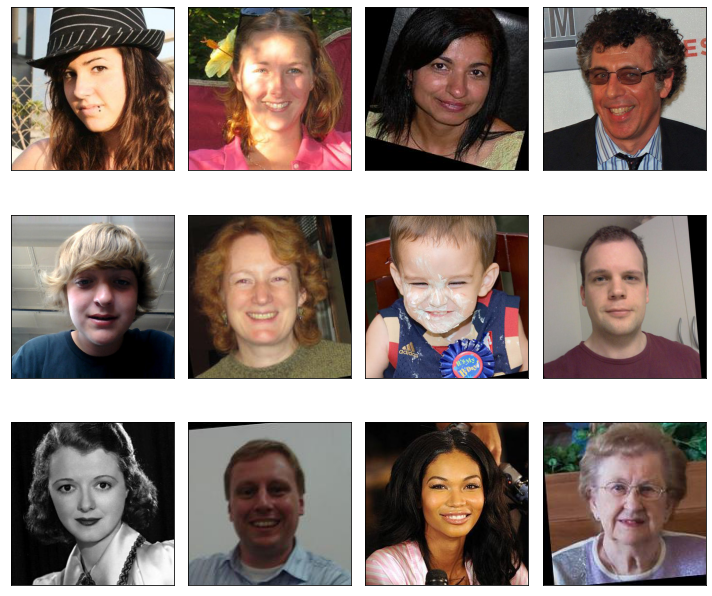

In [6]:
#посмотрим на фотографии, с которыми будет работать модель

photo = os.listdir(path + '/final_files/')
fig = plt.figure(figsize=(10,10))
n = 0
for i in random.sample(photo, 12):
    img = Image.open(path + '/final_files/' + i)
    fig.add_subplot(3, 4, n+1)
    plt.imshow(np.array(img))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    n+=1

Датасет представлен 7591 фотографиями. Основная масса фото в выборке относится к людям до 40 лет.  
На фотографиях присутствуют объекты, которые закрывают лицо: рука, жвачка, очки, головной убор и т.д.  
В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси.   

Чтобы улучшить качество модели можно:
- сделать часть фотографий обучающей выборки черно-белой
- обрезать края изображений чтобы избавится от артефактов, затемненных краев и обстановки
- обогатить выборку зеркальными отражениями

## Обучение модели

### Код обучения модели


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 horizontal_flip=True, 
                                 rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

### Результат обучения
```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 68s - loss: 203.7682 - mae: 10.2884 - val_loss: 399.6740 - val_mae: 14.9290
Epoch 2/10
356/356 - 57s - loss: 82.4470 - mae: 6.8724 - val_loss: 130.7843 - val_mae: 8.4827
Epoch 3/10
356/356 - 56s - loss: 58.5220 - mae: 5.8475 - val_loss: 79.1671 - val_mae: 6.8190
Epoch 4/10
356/356 - 55s - loss: 43.0843 - mae: 5.0169 - val_loss: 79.4058 - val_mae: 6.7744
Epoch 5/10
356/356 - 55s - loss: 31.1383 - mae: 4.3012 - val_loss: 64.4459 - val_mae: 5.9622
Epoch 6/10
356/356 - 54s - loss: 24.3450 - mae: 3.7672 - val_loss: 80.4652 - val_mae: 6.9309
Epoch 7/10
356/356 - 55s - loss: 20.6203 - mae: 3.4227 - val_loss: 66.5386 - val_mae: 6.1614
Epoch 8/10
356/356 - 56s - loss: 17.3958 - mae: 3.1634 - val_loss: 75.5891 - val_mae: 6.6833
Epoch 9/10
356/356 - 57s - loss: 15.3914 - mae: 2.9887 - val_loss: 90.9327 - val_mae: 7.5245
Epoch 10/10
356/356 - 57s - loss: 13.4849 - mae: 2.8001 - val_loss: 66.0554 - val_mae: 6.1351
119/119 - 11s - loss: 66.0554 - mae: 6.1351
Test MAE: 6.1351

```

## Анализ обученной модели

В результате исследования была построена модель с использованием архитектуры ResNet50 (использован бэкбон, верхушка отключена и сконструирована заново) с предобученными весами основанных на `ImageNet` для системы компьютерного зрения.  
Для обучения модели использовались следующие параметры:
- размер батча - 16;
- оптимизатор Adam с шагом 0.0001;
- веса бэкбона не замораживались;
- количество эпох - 10.

Модель позволяет с помощью фотофиксации в прикассовой зоне определять возраст клиентов со средней абсолютной ошибкой (MAE) 6.14.

Полученная модель полностью соответствует требованиям заказчика. Цель достигнута.